In [1]:
import numpy as np
import pandas as pd
from random import shuffle
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
import torchvision
from torch.utils.data import DataLoader, Dataset, random_split, ConcatDataset
from torchvision import transforms, datasets, models
from train import train_model, train_loss, train_accuracy, val_loss, val_accuracy
from torchsummary import summary
import time
import copy
import seaborn as sns
sns.set(font_scale=1.4)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

batch_size = 32

In [2]:
def norm(dataset):
    output = []
    for sample in tqdm(dataset):
        newimg = []
        img = sample[0]
        label = sample[1]
        for s in img:
            s = s[0]
            s /= torch.max(s)
            s = torch.stack([s, s, s], 0)
            newimg.append(s)
        output.append((newimg, label))
    return output

dataset = torch.load('../../datasets/64dataset.pt')
dataset = norm(dataset)


extraAD1 = torch.load('../../datasets/GAN_noSS/64ADgan1noSS.pt')
extraAD2 = torch.load('../../datasets/GAN_noSS/64ADgan2noSS.pt')
extraAD3 = torch.load('../../datasets/GAN_noSS/64ADgan3noSS.pt')

extraNC1 = torch.load('../../datasets/GAN_noSS/64NCgan1noSS.pt')
extraNC2 = torch.load('../../datasets/GAN_noSS/64NCgan2noSS.pt')
extraNC3 = torch.load('../../datasets/GAN_noSS/64NCgan3noSS.pt')

extraAD = [([extraAD1[j][0], extraAD2[j][0], extraAD3[j][0]], extraAD1[j][1]) 
              for j in tqdm(range(len(extraAD1))) ]
extraNC = [([extraNC1[j][0], extraNC2[j][0], extraNC3[j][0]], extraNC1[j][1]) 
              for j in tqdm(range(len(extraNC1))) ]

dataset = torch.utils.data.ConcatDataset((dataset, extraNC, extraAD))

lengths = [

    int(len(dataset) * 0.8),
    int(len(dataset) * 0.1),
    int(len(dataset) * 0.1) + 1
]


trainset, valset, testset = random_split(dataset, lengths)


image_datasets = {'train': trainset, 'val': valset, 'test': testset}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4)
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}  

In [3]:
class MultiCNN(nn.Module):
    def __init__(self):
        super(MultiCNN, self).__init__()
        self.fc1 = nn.Linear(6144, 256)
        self.fc2 = nn.Linear(256, 2)
        self.fc3 = nn.Linear(10, 2)
        resnet = models.resnet50(pretrained=True).to(device) 
        self.new_resnet1 = nn.Sequential(*list(resnet.children())[:-1])
        self.new_resnet2 = nn.Sequential(*list(resnet.children())[:-1])
        self.new_resnet3 = nn.Sequential(*list(resnet.children())[:-1])
        self.drop = nn.Dropout(p=0.5)
        
    def forward(self, x_slices):

        x1 = x_slices[0]
        x1 = self.new_resnet1(x1)
        x1 = x1.view(-1, 2048)

        x2 = x_slices[1]
        x2 = self.new_resnet2(x2)
        x2 = x2.view(-1, 2048)

        x3 = x_slices[2]
        x3 = self.new_resnet3(x3)
        x3 = x3.view(-1, 2048)

        out = torch.cat((x1, x2, x3), dim=-1)
        out = F.relu(self.drop(self.fc1(out)))
        out = F.relu(self.fc2(out))

        return out

Epoch 0/24
----------------------------------------------------------------------------------------------------



train Loss: 0.5583 Acc: 0.7438



val Loss: 0.4718 Acc: 0.8814
Epoch 1/24
----------------------------------------------------------------------------------------------------



train Loss: 0.3761 Acc: 0.8174



val Loss: 0.2986 Acc: 0.8686
Epoch 2/24
----------------------------------------------------------------------------------------------------



train Loss: 0.2149 Acc: 0.9015



val Loss: 0.3712 Acc: 0.8856
Epoch 3/24
----------------------------------------------------------------------------------------------------



train Loss: 0.1248 Acc: 0.9582



val Loss: 0.4247 Acc: 0.8814
Epoch 4/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0861 Acc: 0.9693



val Loss: 0.5246 Acc: 0.8941
Epoch 5/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0943 Acc: 0.9809



val Loss: 0.3829 Acc: 0.9195
Epoch 6/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0804 Acc: 0.9783



val Loss: 0.6754 Acc: 0.8729
Epoch 7/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0683 Acc: 0.9884



val Loss: 0.9448 Acc: 0.8559
Epoch 8/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0139 Acc: 0.9974



val Loss: 0.5199 Acc: 0.9110
Epoch 9/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0089 Acc: 0.9989



val Loss: 0.5816 Acc: 0.8941
Epoch 10/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0132 Acc: 0.9979



val Loss: 0.3741 Acc: 0.9153
Epoch 11/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0272 Acc: 0.9979



val Loss: 0.6886 Acc: 0.8856
Epoch 12/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0064 Acc: 0.9984



val Loss: 0.9383 Acc: 0.8602
Epoch 13/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0101 Acc: 1.0000



val Loss: 0.5582 Acc: 0.8983
Epoch 14/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0079 Acc: 0.9995



val Loss: 0.5797 Acc: 0.9025
Epoch 15/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0456 Acc: 0.9984



val Loss: 0.3094 Acc: 0.9364
Epoch 16/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0319 Acc: 0.9984



val Loss: 0.5506 Acc: 0.8983
Epoch 17/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0284 Acc: 0.9995



val Loss: 0.2676 Acc: 0.9449
Epoch 18/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0057 Acc: 0.9989



val Loss: 0.3469 Acc: 0.9322
Epoch 19/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0106 Acc: 0.9989



val Loss: 1.0606 Acc: 0.8390
Epoch 20/24
----------------------------------------------------------------------------------------------------



train Loss: 0.1013 Acc: 0.9984



val Loss: 0.7311 Acc: 0.9025
Epoch 21/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0092 Acc: 0.9979



val Loss: 0.3142 Acc: 0.9407
Epoch 22/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0299 Acc: 0.9995



val Loss: 0.7044 Acc: 0.8941
Epoch 23/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0043 Acc: 0.9995



val Loss: 0.2904 Acc: 0.9364
Epoch 24/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0063 Acc: 0.9995



val Loss: 0.3509 Acc: 0.9237
Training complete in 3m 4s
Best val Acc: 0.944915


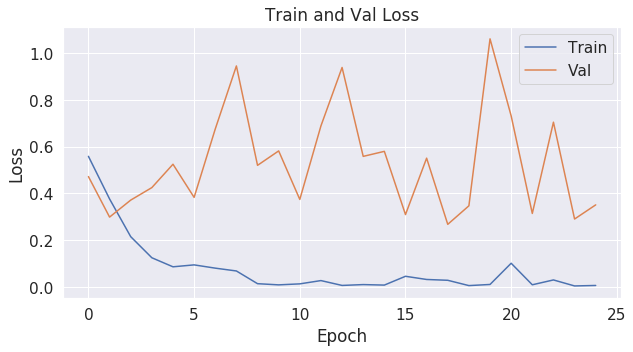

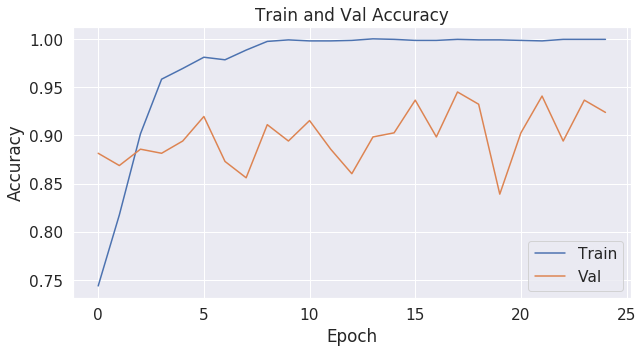

In [4]:
model = MultiCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
model = train_model(model, criterion, optimizer, exp_lr_scheduler, dataloaders, dataset_sizes,
                       num_epochs=25, batch_size = batch_size)

In [5]:
running_loss = 0.0
running_corrects = 0
for inputs, labels in tqdm(dataloaders['test'], total = dataset_sizes['test']//32+1):
    labels = labels.to(device)
    inputs = [i.to(device, dtype = torch.float) for i in inputs]

    with torch.no_grad():
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)


    running_loss += loss.item() * 32
    running_corrects += torch.sum(preds == labels.data)
    
print(f"Test Loss: {running_loss / dataset_sizes['test']}\nTest Accuracy: {running_corrects.double() / dataset_sizes['test']}")



Test Loss: 0.5413560107790468
Test Accuracy: 0.8987341772151898


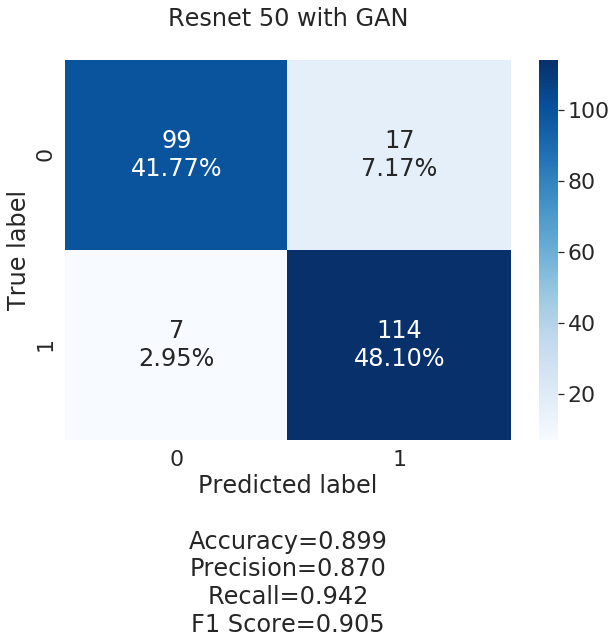

In [7]:
from confusionmatrix import make_confusion_matrix
sns.set(font_scale = 2)
nb_classes = 2
cf = torch.zeros(nb_classes, nb_classes)

with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['test']):
        classes = classes.to(device)
        inputs = [i.to(device, dtype=torch.float) for i in inputs]
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        for t, p in zip(classes.view(-1), preds.view(-1)):
            cf[t.long(), p.long()] += 1

cf = np.array(cf)

group_names = ['bruh','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf.reshape(-1)/cf.sum()]

labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]

make_confusion_matrix(cf, group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize= (10,7),
                          cmap='Blues',
                          title='Resnet 50 with GAN\n')